In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings; warnings.filterwarnings(action='ignore')
# --------------------------------------------------
 
# --------------------------------------------------
# load datasets
from sklearn import datasets
 
# imblearn.sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
 
# preprocessing.encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder # pd.get_dummies()
# preprocessing.scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
# preprocessing.binarizing
from sklearn.preprocessing import Binarizer
 
# decomposition.PCA
from sklearn.decomposition import PCA
 
 
# Classifier ---------------------------------------
 
# estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression # classifier
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
# metrics.scores
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.metrics import log_loss
# metrics.curves
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, plot_roc_curve
# metrics.reports
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
# --------------------------------------------------
 
# Regressor-----------------------------------------
# estimators
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor, XGBRFRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, CatBoostError
# metrics.errors
from sklearn.metrics import mean_squared_error     # 'neg_mean_squared_error', 'neg_root_mean_squared_error'
from sklearn.metrics import mean_squared_log_error # 'neg_mean_squared_log_error'
from sklearn.metrics import mean_absolute_error    # 'neg_mean_absolute_error'
# --------------------------------------------------
 
# stats : R module
from scipy.stats import skew, kurtosis
 
# model_selection.splitter
from sklearn.model_selection import train_test_split       # function
# model_selection.model_validation
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold # cross-validator
from sklearn.model_selection import cross_validate, cross_val_score
# model_selection.hyper_parameter_optimizer
from sklearn.model_selection import GridSearchCV
 
# **************************************************
 
# --------------------------------------------------
def check_nan(df):
    nan = df.isna().sum()[df.isna().sum() != 0]
    nan_cols = list(nan.index)
    nan_cnt  = df[nan_cols].isna().sum()
    rate = round(nan_cnt / df.shape[0] * 100, 2)
    nan_df = pd.DataFrame({'NAN_CNT':nan_cnt, 'RATE':rate})
    
    print(nan_df)
    print('-' * 30)
    print('nan_cols count =', len(nan_cols))
    print(nan_cols)
 
    for col in nan_cols:
        print('-' * 30)
        print(df[col].value_counts())
        print('value_counts =', df[col].count(), '/ nan_counts =', df[col].isna().sum())
    
    return nan_cols
# nan_cols = check_nan(df)
# --------------------------------------------------
 
# --------------------------------------------------
def check_outliers(X_train, features, rate=1.5):
    
    dict = {}
    
    for col in features:
        
        Q1 = np.percentile(X_train[col], 25) 
        Q3 = np.percentile(X_train[col], 75) 
        IQR = Q3 - Q1
        
        min = Q1 - (rate * IQR)
        max = Q3 + (rate * IQR)
        
        idxs = X_train[(X_train[col] < min) | (X_train[col] > max)].index
        
        dict[col] = idxs
        
    return dict
# check_outliers(X_train, 'Insulin')
# --------------------------------------------------
 
# --------------------------------------------------
def check_object(df):
    object_cols = list(df.dtypes[df.dtypes == 'object'].index)
    print('object_cols count =', len(object_cols))
    for col in object_cols:
        print('-' * 30)
        print(df[col].value_counts())
    return object_cols
# object_cols = encode(df)
# --------------------------------------------------
 
# --------------------------------------------------
def mapping(df, col, dict):
    dict = {}
    
    for i in range(len(df[col].value_counts().index)):
        dict[df[col].value_counts().index[i]] = i
    
    df['e_' + col] = df[col].map(dict)
    return df['e_' + col].value_counts()
# mapping(df, 'gender')
# --------------------------------------------------
 
# --------------------------------------------------
def split_xy(df, target, test_size=0.2):
    
    """split X, y & train, test"""
    
    X = df.drop(target, axis=1)
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0, stratify=y)
    
    return X_train, X_test, y_train, y_test
 
# X_train, X_test, y_train, y_test = split_xy(df, 'Outcome')
# --------------------------------------------------
 
# --------------------------------------------------
def scores(y_test, y_pred):
    
    """evaluation scores"""
    
    f1        = f1_score         (y_test, y_pred, average='macro')
    accuracy  = accuracy_score   (y_test, y_pred, )
    precision = precision_score  (y_test, y_pred, average='macro')
    recall    = recall_score     (y_test, y_pred, average='macro')
    c_matrix  = confusion_matrix (y_test, y_pred, )
    
    print(
          f'accuracy  = {accuracy:.6f},  '
          f'f1 score  = {f1:.6f},  \n'
          f'precision = {precision:.6f},  '
          f'recall    = {recall:.6f},')
    print(c_matrix)
    
    # plt.figure(figsize=(12, 9))
    # plt.title('confusion matrix')
    # plt.xlabel('Predict')
    # plt.ylabel('Actual')
    # sns.heatmap(c_matrix, annot=True, linewidths=1, cmap='Blues', annot_kws={"size": 14})
    # plt.show()
# --------------------------------------------------
 
# --------------------------------------------------
def curves(y_test, probas_pred):
        
    FPRS, TPRS, thresholds = roc_curve(y_test, probas_pred[:, 1])
 
    f, ax = plt.subplots(1, 2, figsize=(16, 6))
 
    # settings
    plt.subplot(121)
    plt.title('ROC curve')
    plt.gray()
    plt.xlabel('FPR(1- specificity)')
    plt.ylabel('TPR')
 
    # x, y values
    plt.plot(FPRS, TPRS, label='ROC', linestyle='solid')
    plt.plot([0, 1], [0, 1], label='50%', color='gray', linestyle=':')
    plt.legend()
 
    precisions, recalls, thresholds = precision_recall_curve(y_test, probas_pred[:, 1])
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
 
    plt.subplot(122)
    plt.title('precision recall curve')
    plt.gray()
    plt.xlabel('threshold')
    plt.ylabel('scores')
 
    # x, y values
    plt.plot(thresholds, precisions[:thresholds.shape[0]], label='precision', linestyle=':')
    plt.plot(thresholds, recalls[:thresholds.shape[0]],    label='recall',    linestyle='--')
    plt.plot(thresholds, f1_scores[:thresholds.shape[0]],  label='f1',        linestyle='solid')
    # valid linestyle = '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'
    plt.legend()
 
    plt.show()
    
    print('AUC = ', roc_auc_score(y_test, probas_pred[:, 1]))
# --------------------------------------------------
# --------------------------------------------------

# read

In [2]:
train = pd.read_csv('./kaggle/DACON_credit_card_overdue/train.csv')
X_sub = pd.read_csv('./kaggle/DACON_credit_card_overdue/test.csv')
y_sub = pd.read_csv('./kaggle/DACON_credit_card_overdue/sample_submission.csv')

df = pd.concat([train, X_sub])
nan_cols = check_nan(df)
object_cols = check_object(df)

            NAN_CNT   RATE
occyp_type     8171  30.88
credit         5456  20.62
------------------------------
nan_cols count = 2
['occyp_type', 'credit']
------------------------------
Laborers                 4512
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64
value_counts = 18286 / nan_counts = 8171
------------------------------
2.0    13503
1.0     4942
0.0     2556
Name: credit, dtype: int64
value_counts = 21001 / nan_counts = 5456
object_cols count = 8
------------------------------
F    17697

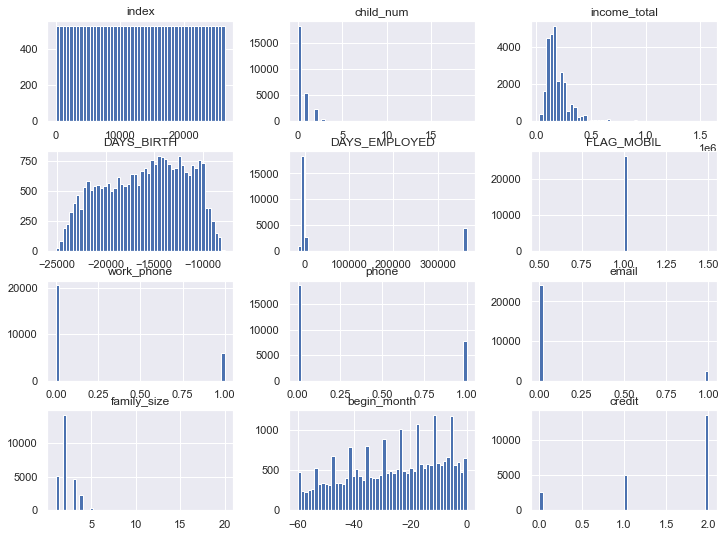

In [3]:
df.hist(figsize=(12, 9), bins=50); plt.show()

# df ver00

## encode

### gender : 0 1 2

In [4]:
map_gender = {'M':0, 'F':1}
df['en_gender'] = df['gender'].map(map_gender)
print(df[['gender', 'en_gender']].value_counts())
df[['gender', 'en_gender']].head()

gender  en_gender
F       1            17697
M       0             8760
dtype: int64


,gender,en_gender
0,F,1
1,F,1
2,M,0
3,F,1
4,F,1


### car : 0 1

In [5]:
map_car = {'N':0, 'Y':1}
df['en_car'] = df['car'].map(map_car)
print(df[['car', 'en_car']].value_counts())
df[['car', 'en_car']].head()

car  en_car
N    0         16410
Y    1         10047
dtype: int64


,car,en_car
0,N,0
1,N,0
2,Y,1
3,N,0
4,Y,1


### reality : 0 1

In [6]:
map_reality = {'N':0, 'Y':1}
df['en_reality'] = df['reality'].map(map_reality)
print(df[['reality', 'en_reality']].value_counts())
df[['reality', 'en_reality']].head()

reality  en_reality
Y        1             17830
N        0              8627
dtype: int64


,reality,en_reality
0,N,0
1,Y,1
2,Y,1
3,Y,1
4,Y,1


### edu_type : 0 1 2 3 4

In [7]:
map_edu_type = {'Secondary / secondary special':1, 'Higher education':3, 
                'Incomplete higher':2, 'Lower secondary':0, 'Academic degree':4}
df['en_edu_type'] = df['edu_type'].map(map_edu_type)
print(df[['edu_type', 'en_edu_type']].value_counts())
df[['edu_type', 'en_edu_type']].head()

edu_type                       en_edu_type
Secondary / secondary special  1              17995
Higher education               3               7162
Incomplete higher              2               1020
Lower secondary                0                257
Academic degree                4                 23
dtype: int64


,edu_type,en_edu_type
0,Higher education,3
1,Secondary / secondary special,1
2,Higher education,3
3,Secondary / secondary special,1
4,Higher education,3


### DAYS_BIRTH : (-) -> (+)

In [8]:
df['en_DAYS_BIRTH'] = - df['DAYS_BIRTH']
df['en_DAYS_BIRTH'].head()

0    13899
1    11380
2    19087
3    15088
4    15037
Name: en_DAYS_BIRTH, dtype: int64

### DAYS_EMPLOYED : (-) -> (+)

In [9]:
df['en_DAYS_EMPLOYED'] = - df['DAYS_EMPLOYED']
df['en_DAYS_EMPLOYED'].head()

0    4709
1    1540
2    4434
3    2092
4    2105
Name: en_DAYS_EMPLOYED, dtype: int64

### begin_month : (-) -> (+)

In [10]:
df['en_begin_month'] = - df['begin_month']
df['en_begin_month'].value_counts()

7     662
11    617
8     612
3     593
6     591
     ... 
58    244
59    242
60    235
0     231
57    228
Name: en_begin_month, Length: 61, dtype: int64

### DAYS_EMPLOYED : (-) -> (+)

<AxesSubplot:>

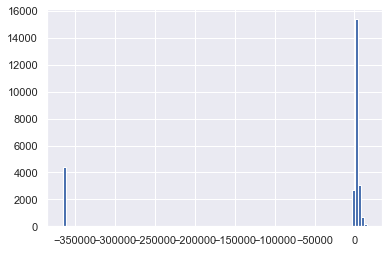

In [11]:
df['en_DAYS_EMPLOYED'] = - df['DAYS_EMPLOYED']
df['en_DAYS_EMPLOYED'].hist(bins=100)

### dummies : 'income_type', 'family_type', 'house_type', 'occyp_type'

In [12]:
dummy_cols = ['income_type', 'family_type', 'house_type', ]
dummy_df1 = pd.get_dummies(df, dummy_na=True, columns=['occyp_type']).iloc[:, 26:]
dummy_df2 = pd.get_dummies(df, columns=dummy_cols).iloc[:, 24:]

In [13]:
df = pd.concat([df, dummy_df1, dummy_df2], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26457 entries, 0 to 5455
Data columns (total 62 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   index                             26457 non-null  int64  
 1   gender                            26457 non-null  object 
 2   car                               26457 non-null  object 
 3   reality                           26457 non-null  object 
 4   child_num                         26457 non-null  int64  
 5   income_total                      26457 non-null  float64
 6   income_type                       26457 non-null  object 
 7   edu_type                          26457 non-null  object 
 8   family_type                       26457 non-null  object 
 9   house_type                        26457 non-null  object 
 10  DAYS_BIRTH                        26457 non-null  int64  
 11  DAYS_EMPLOYED                     26457 non-null  int64  
 12  FLAG_

### drop endcoded

In [14]:
dropped_df = df.drop(['index', 'child_num','gender', 'car', 'FLAG_MOBIL', 'reality', 'edu_type', 
                      'DAYS_BIRTH', 'DAYS_EMPLOYED', 'begin_month', 'occyp_type', 
                      'income_type', 'family_type', 'house_type'], axis=1)

## corr

### heatmap

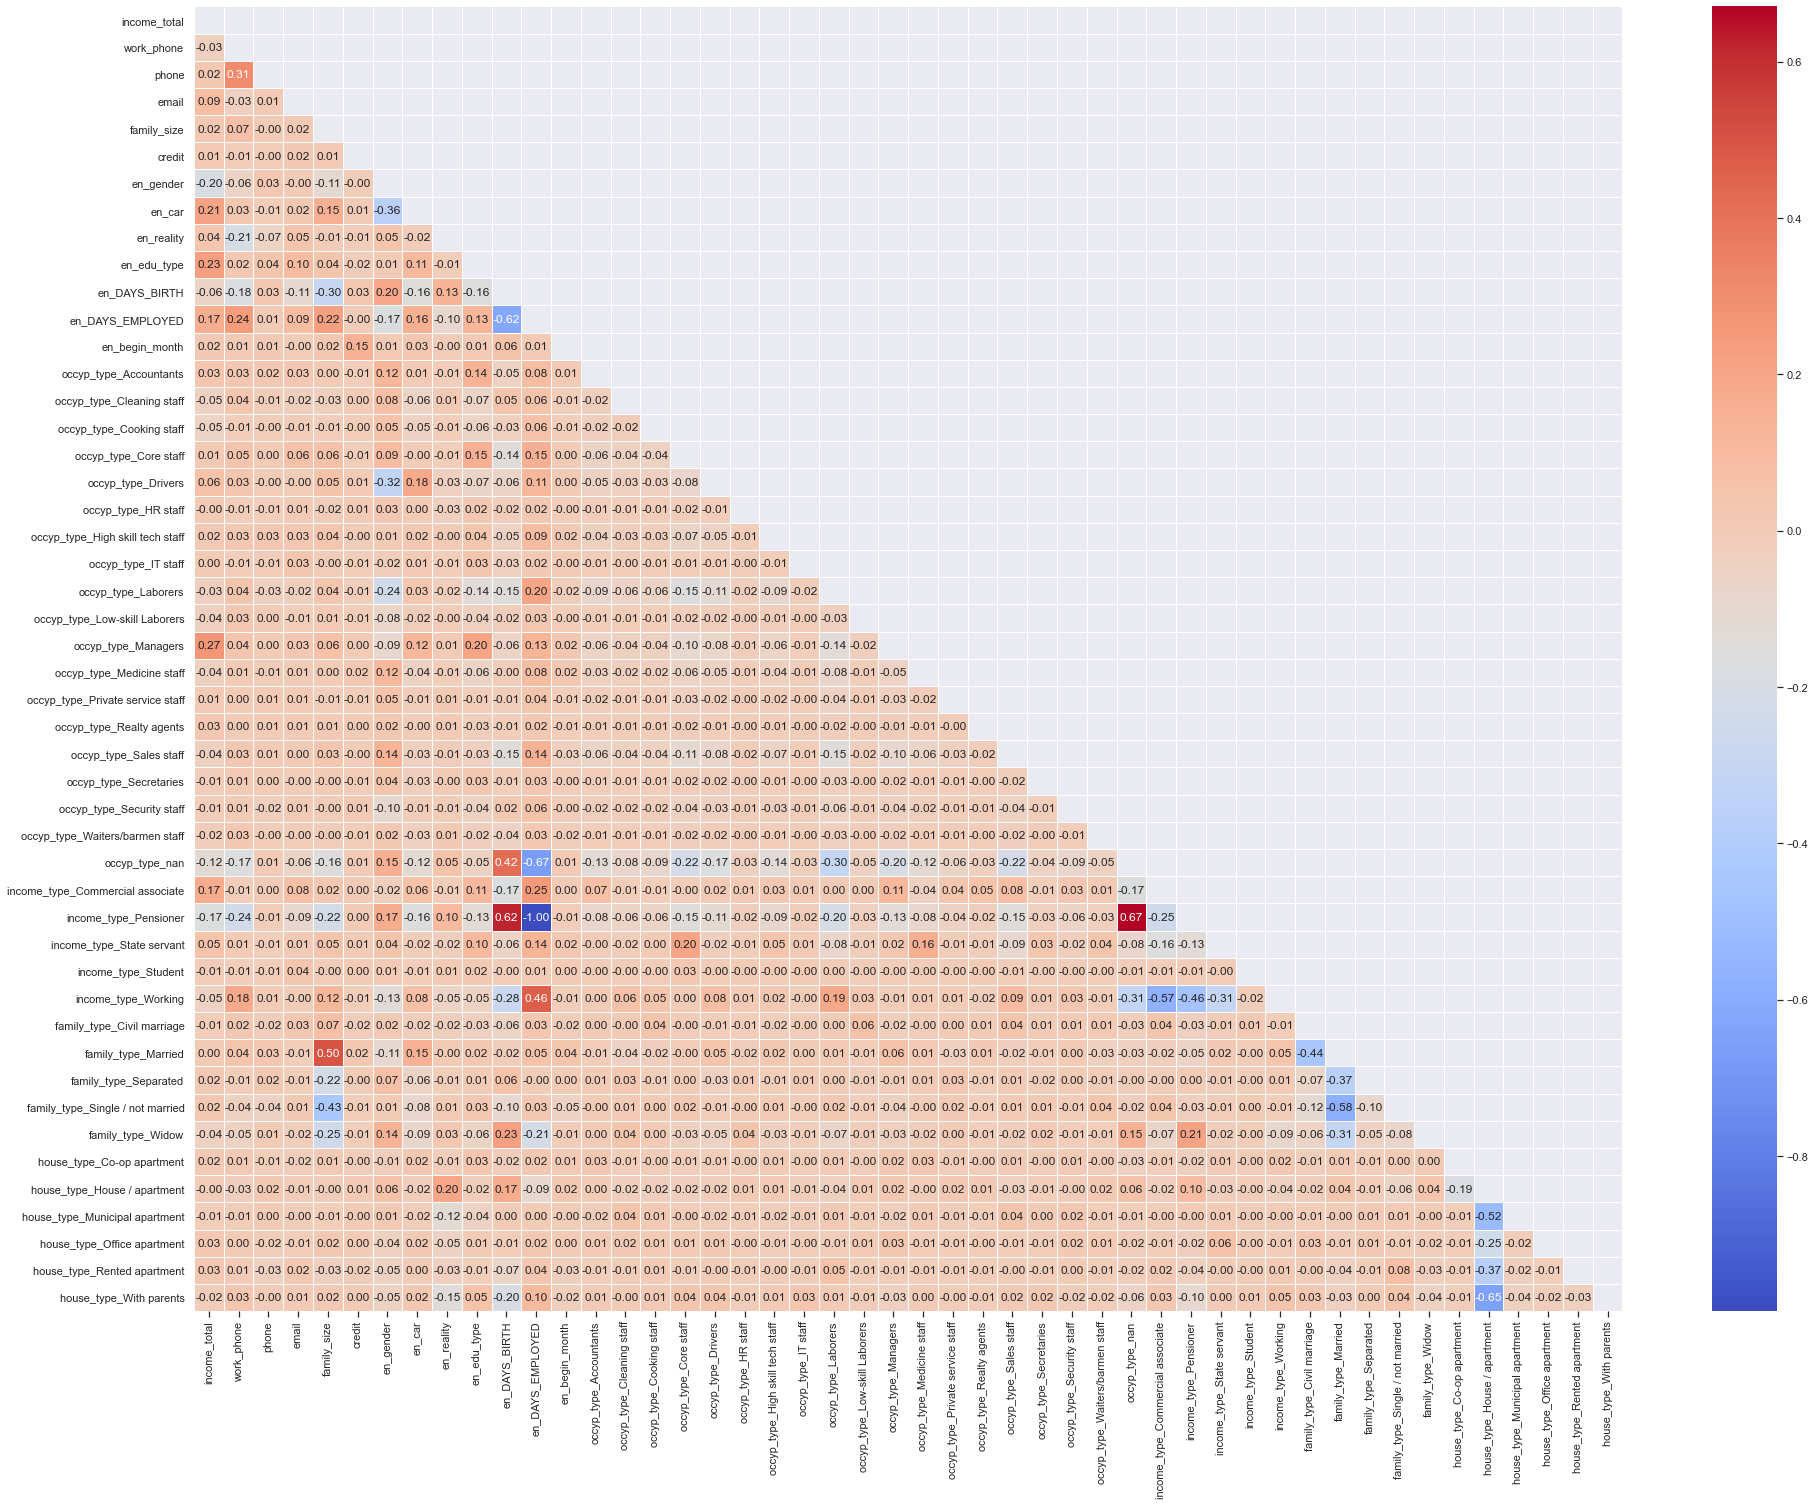

In [15]:
fig, ax = plt.subplots(figsize=(32, 24))
mask = np.triu(np.ones_like(dropped_df.corr()))
sns.heatmap(dropped_df.corr(), annot=True, fmt=".2f", linewidths=.7, cmap='coolwarm', mask=mask)
ax.xaxis.set_ticks_position('bottom')
plt.show()

### corr_dict

In [16]:
ddf_corr = dropped_df.corr()[(dropped_df.corr() >= 0.3) | (dropped_df.corr() <= -0.3)]; ddf_corr.head()

corr_dict = {}

for col in ddf_corr.columns:
    # corr_dict[col] = list(ddf_corr[ddf_corr[col].notna() == True].index)
    
    corr_val_dict = {}
    
    for i in ddf_corr[ddf_corr[col].notna() == True].index:
        corr_val_dict[i] = ddf_corr.loc[i, col]
    
    corr_dict[col] = corr_val_dict
    corr_dict[col].pop(col)
    
corr_dict

{'income_total': {},
 'work_phone': {'phone': 0.31025552177022986},
 'phone': {'work_phone': 0.31025552177022986},
 'email': {},
 'family_size': {'family_type_Married': 0.49774118783914,
  'family_type_Single / not married': -0.43384006303199124},
 'credit': {},
 'en_gender': {'en_car': -0.36232004536329576,
  'occyp_type_Drivers': -0.3233153996544083},
 'en_car': {'en_gender': -0.36232004536329576},
 'en_reality': {},
 'en_edu_type': {},
 'en_DAYS_BIRTH': {'en_DAYS_EMPLOYED': -0.6167763048502786,
  'occyp_type_nan': 0.4206888321552782,
  'income_type_Pensioner': 0.6201540359431967},
 'en_DAYS_EMPLOYED': {'en_DAYS_BIRTH': -0.6167763048502786,
  'occyp_type_nan': -0.6712182539097292,
  'income_type_Pensioner': -0.9983984642043651,
  'income_type_Working': 0.4632159816570183},
 'en_begin_month': {},
 'occyp_type_Accountants': {},
 'occyp_type_Cleaning staff': {},
 'occyp_type_Cooking staff': {},
 'occyp_type_Core staff': {},
 'occyp_type_Drivers': {'en_gender': -0.3233153996544083},
 'oc

## null

In [17]:
df00 = dropped_df
check_nan(df00)

        NAN_CNT   RATE
credit     5456  20.62
------------------------------
nan_cols count = 1
['credit']
------------------------------
2.0    13503
1.0     4942
0.0     2556
Name: credit, dtype: int64
value_counts = 21001 / nan_counts = 5456


['credit']

In [18]:
df00.head()

,income_total,work_phone,phone,email,family_size,credit,en_gender,en_car,en_reality,en_edu_type,...,family_type_Married,family_type_Separated,family_type_Single / not married,family_type_Widow,house_type_Co-op apartment,house_type_House / apartment,house_type_Municipal apartment,house_type_Office apartment,house_type_Rented apartment,house_type_With parents
0,202500.0,0,0,0,2,1.0,1,0,0,3,...,1,0,0,0,0,0,1,0,0,0
1,247500.0,0,0,1,3,1.0,1,0,1,1,...,0,0,0,0,0,1,0,0,0,0
2,450000.0,0,1,0,2,2.0,0,1,1,3,...,1,0,0,0,0,1,0,0,0,0
3,202500.0,0,1,0,2,0.0,1,0,1,1,...,1,0,0,0,0,1,0,0,0,0
4,157500.0,0,0,0,2,2.0,1,1,1,3,...,1,0,0,0,0,1,0,0,0,0


In [19]:
df00.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26457 entries, 0 to 5455
Data columns (total 48 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   income_total                      26457 non-null  float64
 1   work_phone                        26457 non-null  int64  
 2   phone                             26457 non-null  int64  
 3   email                             26457 non-null  int64  
 4   family_size                       26457 non-null  int64  
 5   credit                            21001 non-null  float64
 6   en_gender                         26457 non-null  int64  
 7   en_car                            26457 non-null  int64  
 8   en_reality                        26457 non-null  int64  
 9   en_edu_type                       26457 non-null  int64  
 10  en_DAYS_BIRTH                     26457 non-null  int64  
 11  en_DAYS_EMPLOYED                  26457 non-null  int64  
 12  en_be

In [20]:
df00.isna().sum()

income_total                           0
work_phone                             0
phone                                  0
email                                  0
family_size                            0
credit                              5456
en_gender                              0
en_car                                 0
en_reality                             0
en_edu_type                            0
en_DAYS_BIRTH                          0
en_DAYS_EMPLOYED                       0
en_begin_month                         0
occyp_type_Accountants                 0
occyp_type_Cleaning staff              0
occyp_type_Cooking staff               0
occyp_type_Core staff                  0
occyp_type_Drivers                     0
occyp_type_HR staff                    0
occyp_type_High skill tech staff       0
occyp_type_IT staff                    0
occyp_type_Laborers                    0
occyp_type_Low-skill Laborers          0
occyp_type_Managers                    0
occyp_type_Medic

# met ver00

In [21]:
# INPUT DF VERSION
df_met = df00

# (train, sub) & (X, y) & (train, tset) split
train_met = df_met[df_met['credit'].notna()]

X = train_met.drop('credit', axis=1)
y = train_met['credit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,
                                                    shuffle=True, stratify=y)

# models
models = [
          RandomForestClassifier(), 
          GradientBoostingClassifier(), 
          XGBClassifier(), 
          XGBRFClassifier(), 
          LGBMClassifier(), 
          CatBoostClassifier(),
          ]

# param_grid=
hyper_param = {'n_estimators':[2, 3, 4],
               'random_state':[0],
            #    'min_samples_split':[2],
            #    'min_samples_leaf':[1],
               }

# scoring=
scorers = {'f1_macro':'f1_macro', 'accuracy':'accuracy',
           'precision':'precision_macro', 'recall':'recall_macro', 'roc_auc_ovr':'roc_auc_ovr',}
# cv=
skfold  = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# cv_results_ cols
result_scorers = ['mean_test_f1_macro', 'mean_test_accuracy', 
                  'mean_test_precision', 'mean_test_recall', 'mean_test_roc_auc_ovr',]

# GridSearchCV loop
for model in models:
    
    gscv = GridSearchCV(model, param_grid=hyper_param, scoring=scorers, 
                        refit='f1_macro', cv=skfold, return_train_score=True)
    gscv.fit(X, y)
    
    results = gscv.cv_results_
    
    print('-' * 75)
    print('estimtor        =', gscv.estimator)
    print('best_params_    =', gscv.best_params_)
    print('best_score_     =', gscv.best_score_)
    met_df = pd.DataFrame(results)[result_scorers]
    met_df.columns = ['f1_macro', 'accuracy', 'precision', 'recall', 'auc_ovr',]
    print(met_df)

---------------------------------------------------------------------------
estimtor        = RandomForestClassifier()
best_params_    = {'n_estimators': 4, 'random_state': 0}
best_score_     = 0.5227959251578316
   f1_macro  accuracy  precision    recall   auc_ovr
0  0.466111  0.543832   0.463941  0.494509  0.658957
1  0.515040  0.646064   0.520445  0.512130  0.680062
2  0.522796  0.642398   0.523674  0.522428  0.692153
---------------------------------------------------------------------------
estimtor        = GradientBoostingClassifier()
best_params_    = {'n_estimators': 4, 'random_state': 0}
best_score_     = 0.3753771629397821
   f1_macro  accuracy  precision    recall   auc_ovr
0  0.260897  0.642969   0.214323  0.333333  0.600996
1  0.260897  0.642969   0.214323  0.333333  0.601582
2  0.375377  0.688681   0.488397  0.398726  0.603703
[10:13:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evalu

# df ver01 : df00 + oversamp

In [22]:
train01 = df00[df00['credit'].notna()]
X_sub01 = df00[df00['credit'].isna()]

train01.shape, X_sub01.shape

((21001, 48), (5456, 48))

In [23]:
X_train01 = train01.drop('credit', axis=1)
y_train01 = train01['credit']
X_train01.shape, y_train.shape

((21001, 47), (16800,))

In [24]:
smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train01, y_train01)
X_train_over.shape, y_train_over.shape

((40509, 47), (40509,))

In [25]:
train01 = pd.concat([X_train_over, y_train_over], axis=1)
train01.shape

(40509, 48)

In [26]:
df01 = pd.concat([train01, X_sub01])
df01.shape

(45965, 48)

# met ver01

In [27]:
# INPUT DF VERSION
df_met = df01

# (train, sub) & (X, y) & (train, tset) split
train_met = df_met[df_met['credit'].notna()]

X = train_met.drop('credit', axis=1)
y = train_met['credit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,
                                                    shuffle=True, stratify=y)

# models
models = [
          RandomForestClassifier(), 
          GradientBoostingClassifier(), 
          XGBClassifier(), 
          XGBRFClassifier(), 
          LGBMClassifier(), 
          CatBoostClassifier(),
          ]

# param_grid=
hyper_param = {'n_estimators':[2, 3, 4],
               'random_state':[0],
            #    'min_samples_split':[2],
            #    'min_samples_leaf':[1],
               }

# scoring=
scorers = {'f1_macro':'f1_macro', 'accuracy':'accuracy',
           'precision':'precision_macro', 'recall':'recall_macro', 'roc_auc_ovr':'roc_auc_ovr',}
# cv=
skfold  = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# cv_results_ cols
result_scorers = ['mean_test_f1_macro', 'mean_test_accuracy', 
                  'mean_test_precision', 'mean_test_recall', 'mean_test_roc_auc_ovr',]

# GridSearchCV loop
for model in models:
    
    gscv = GridSearchCV(model, param_grid=hyper_param, scoring=scorers, 
                        refit='f1_macro', cv=skfold, return_train_score=True)
    gscv.fit(X, y)
    
    results = gscv.cv_results_
    
    print('-' * 75)
    print('estimtor        =', gscv.estimator)
    print('best_params_    =', gscv.best_params_)
    print('best_score_     =', gscv.best_score_)
    met_df = pd.DataFrame(results)[result_scorers]
    met_df.columns = ['f1_macro', 'accuracy', 'precision', 'recall', 'auc_ovr',]
    print(met_df)

---------------------------------------------------------------------------
estimtor        = RandomForestClassifier()
best_params_    = {'n_estimators': 4, 'random_state': 0}
best_score_     = 0.7237240825196595
   f1_macro  accuracy  precision    recall   auc_ovr
0  0.653214  0.659335   0.676429  0.659334  0.824669
1  0.720127  0.720975   0.721934  0.720974  0.853086
2  0.723724  0.725222   0.726502  0.725221  0.867217
---------------------------------------------------------------------------
estimtor        = GradientBoostingClassifier()
best_params_    = {'n_estimators': 4, 'random_state': 0}
best_score_     = 0.46691149363584483
   f1_macro  accuracy  precision    recall   auc_ovr
0  0.465303  0.485176   0.496069  0.485174  0.655803
1  0.461246  0.485917   0.505060  0.485916  0.662945
2  0.466911  0.493495   0.513170  0.493495  0.666046
[10:14:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default eval

# met ver02

In [28]:
# INPUT DF VERSION
df_met = df01

# (train, sub) & (X, y) & (train, tset) split
train_met = df_met[df_met['credit'].notna()]

X = train_met.drop('credit', axis=1)
y = train_met['credit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0,
                                                    shuffle=True, stratify=y)

# models
models = [
          RandomForestClassifier(),
        #   GradientBoostingClassifier(), 
        #   XGBClassifier(), 
        #   XGBRFClassifier(), 
        #   LGBMClassifier(), 
        #   CatBoostClassifier(),
          ]

# param_grid=
hyper_param = {'n_estimators':[400],
               'random_state':[0],
               'min_samples_split':[4],
               'min_samples_leaf':[1],
               }

# scoring=
scorers = {'f1_macro':'f1_macro', 'accuracy':'accuracy',
           'precision':'precision_macro', 'recall':'recall_macro', 'roc_auc_ovr':'roc_auc_ovr',}
# cv=
skfold  = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

# cv_results_ cols
result_scorers = ['mean_test_f1_macro', 'mean_test_accuracy', 
                  'mean_test_precision', 'mean_test_recall', 'mean_test_roc_auc_ovr',]

# GridSearchCV loop
for model in models:
        
        gscv = GridSearchCV(model, param_grid=hyper_param, scoring=scorers, refit='f1_macro', cv=skfold, return_train_score=True)
        gscv.fit(X, y)
        results = gscv.cv_results_
        
        print('-' * 75)
        print('estimtor        =', gscv.estimator)
        print('best_params_    =', gscv.best_params_)
        print('best_score_     =', gscv.best_score_)
        
        met_df = pd.DataFrame(results)[result_scorers]
        met_df.columns = ['f1_macro', 'accuracy', 'precision', 'recall', 'auc_ovr',]
        print(met_df)

---------------------------------------------------------------------------
estimtor        = RandomForestClassifier()
best_params_    = {'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 400, 'random_state': 0}
best_score_     = 0.7990215005716618
   f1_macro  accuracy  precision    recall   auc_ovr
0  0.799022  0.799526   0.800937  0.799526  0.918484


In [29]:
y_pred = gscv.predict(X_sub01.drop(['credit'], axis=1))
y_pred.shape

(5456,)

In [30]:
y_sub['credit'] = y_pred
y_sub.info(), y_sub.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5456 entries, 0 to 5455
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   5456 non-null   int64  
 1   credit  5456 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 85.4 KB


(None,
    index  credit
 0  21001     2.0
 1  21002     0.0
 2  21003     2.0
 3  21004     2.0
 4  21005     2.0)

In [31]:
y_sub.to_csv('./kaggle/DACON_credit_card_overdue/sub_pjh.csv')

----------------------------------------------------------------------
model = RandomForestClassifier(min_samples_split=4, n_estimators=400, random_state=0)
f1_macro  = 0.7990215005716618   accuracy  = 0.799526046608982   
precision = 0.8009365660753105   recall    = 0.7995255712333338   
AUC_ovr   = 0.9184837125548375  


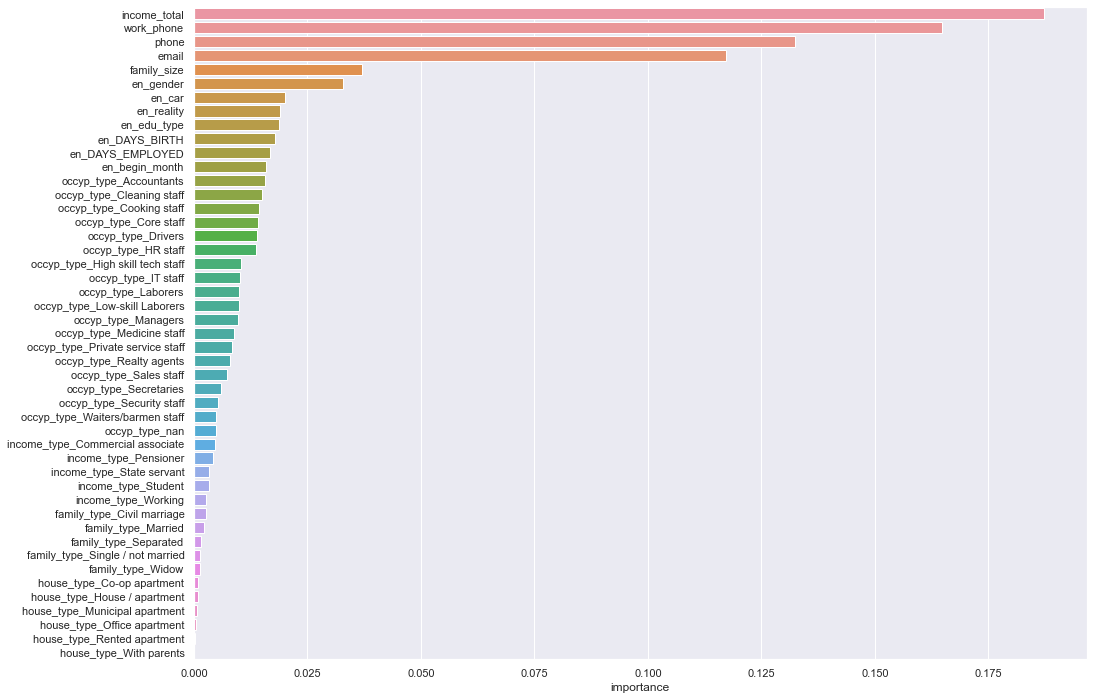

In [32]:
# INPUT DF VERSION
df_met = df01

train_met = df_met[df_met['credit'].notna()]
X = train_met.drop('credit', axis=1)
y = train_met['credit']

models = [
          RandomForestClassifier(n_estimators=400, min_samples_leaf=1, min_samples_split=4, random_state=0),
          ]

scorers = {'f1_macro':'f1_macro', 'accuracy':'accuracy',
           'precision':'precision_macro', 'recall':'recall_macro', 'roc_auc_ovr':'roc_auc_ovr',}
skfold  = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

for model in models:
    
    cv_results = cross_validate(model, X, y, scoring=scorers, cv=skfold, 
                                return_train_score=True, return_estimator=True)
    print('-' * 70)
    print('model =', model)
    print('f1_macro  = {}  '.format(cv_results['test_f1_macro'].mean()),
          'accuracy  = {}  '.format(cv_results['test_accuracy'].mean()), '\n'
          'precision = {}  '.format(cv_results['test_precision'].mean()),
          'recall    = {}  '.format(cv_results['test_recall'].mean()), '\n'
          'AUC_ovr   = {}  '.format(cv_results['test_roc_auc_ovr'].mean()),
          )
    
    fi_list = []
    
    for idx, estimator in enumerate(cv_results['estimator']):
        fi = pd.DataFrame(estimator.feature_importances_, 
                          index=X.columns, columns=['importance']).sort_values('importance', ascending=False)
        
        fi_list.append(estimator.feature_importances_.tolist())
    
    fi_means = np.array(fi_list).mean(axis=0)
    fi_df = pd.DataFrame(fi_means, columns=['importance'], index=X.columns).sort_values(by='importance', ascending=False)
    fig, ax = plt.subplots(figsize=(16, 12))
    sns.set_theme(style='whitegrid')
    sns.set_color_codes('pastel')
    sns.barplot(x='importance', y=X.columns, data=fi_df)
    plt.show()